# Lesson 6: Metaprompting with o1

Optimizing to production is one of the biggest painpoints we've seen developers experience with working with LLMs - with so much guidance for prompt engineering, RAG and fine-tuning out there, figuring out which optimization you need to hill-climb on your evals can be a difficult problem to frame and solve.

Luckily, it appears to be one of the use cases that `o1` is capable at. In this session we'll focus on how to use `o1-mini` to work with a set of evals to optimize our prompt for the task and improve score on our evals.


<div style="background-color:#fff6ff; padding:13px; border-width:3px; border-color:#efe6ef; border-style:solid; border-radius:6px">
<p> 💻 &nbsp; <b>Access <code>requirements.txt</code> and <code>helper.py</code> files:</b> 1) click on the <em>"File"</em> option on the top menu of the notebook and then 2) click on <em>"Open"</em>.

<p> ⬇ &nbsp; <b>Download Notebooks:</b> 1) click on the <em>"File"</em> option on the top menu of the notebook and then 2) click on <em>"Download as"</em> and select <em>"Notebook (.ipynb)"</em>.</p>

<p> 📒 &nbsp; For more help, please see the <em>"Appendix – Tips, Help, and Download"</em> Lesson.</p>

</div>

<p style="background-color:#f7fff8; padding:15px; border-width:3px; border-color:#e0f0e0; border-style:solid; border-radius:6px"> 🚨
&nbsp; <b>Different Run Results:</b> The output generated by AI models can vary with each execution due to their dynamic, probabilistic nature. Don't be surprised if your results differ from those shown in the video.</p>

In [1]:
# Warning control
import warnings
warnings.filterwarnings('ignore')

# Import OpenAI key
from helper import get_openai_api_key
openai_api_key = get_openai_api_key()

In [4]:
from openai import OpenAI
from IPython.display import display, Markdown
import pandas as pd
from concurrent.futures import ThreadPoolExecutor
from functionDefinitions import TOOLS
import csv
import json
import os
import matplotlib.pyplot as plt

GPT_MODEL = 'gpt-4o-mini'
O1_MODEL = 'gpt-5'

client = OpenAI(api_key=openai_api_key)

pd.set_option('display.max_colwidth', None)
pd.set_option('display.max_rows', None)
pd.set_option('display.max_columns', None)


In [5]:
from redlines import Redlines
from IPython.display import display, Markdown

def compare_strings(string1, string2):
    # Create a Redlines object to compare the strings
    diff = Redlines(string1, string2)
    
    # Display the differences using Markdown
    display(Markdown(diff.output_markdown))

# Example usage
string_a = "This is the original text for comparison purposes."
string_b = "This is the modified text to compare for differences."

compare_strings(string_a, string_b)

This is the <span style='color:red;font-weight:700;text-decoration:line-through;'>original </span><span style='color:green;font-weight:700;'>modified </span>text <span style='color:green;font-weight:700;'>to compare </span>for <span style='color:red;font-weight:700;text-decoration:line-through;'>comparison purposes.</span><span style='color:green;font-weight:700;'>differences.</span>

## Step 1: Generate 4o routine (prompt)

We'll take the Flight Cancellation Policy that we have created and convert it to an LLM-based routine with the following prompt.

This process is also a good use of O1, using a purely text document to create instructions and tools for an LLM to make use of. To dive deeper on this topic check out [this cookbook](https://cookbook.openai.com/examples/o1/using_reasoning_for_routine_generation).

In [6]:
with open('originalPolicy/flightCancellationsPolicy.md', 'r') as file:
    flight_cancellation_policy = file.read()
    print(flight_cancellation_policy)

# **Internal Flight Cancellations and Changes Policy**

**Purpose**: This document serves as a detailed guide for internal support agents to handle flight cancellations and changes. The focus is on providing clear instructions, ensuring efficiency, consistency, and customer satisfaction during calls.

**Note**: Always maintain a calm, empathetic tone while assisting customers, especially during stressful situations involving cancellations or major changes.

## **Table of Contents**

1. General Guidelines for Handling Customer Requests  
2. Cancellations: Types and Policies  
3. Changes: Types and Policies  
4. Rebooking Guidelines  
5. Compensation and Refund Rules  
6. Special Cases  
7. FAQs for Common Scenarios

### **1\. General Guidelines for Handling Customer Requests**

* **Confirm Identity**: Verify the customer's identity by asking for their booking reference and any additional required details (e.g., name and flight number).  
* **Listen and Understand**: Clarify if the custo

In [7]:
CONVERSION_PROMPT = f"""
You are a helpful assistant tasked with taking an external facing help center article and converting it into a internal-facing programmatically executable routine optimized for an LLM. 
The LLM using this routine will be tasked with reading the policy, answering incoming questions from customers, and helping drive the case toward resolution.

Please follow these instructions:
1. **Review the customer service policy carefully** to ensure every step is accounted for. It is crucial not to skip any steps or policies.
2. **Organize the instructions into a logical, step-by-step order**, using the specified format. 
3. **Use the following format**:
   - **Main actions are numbered** (e.g., 1, 2, 3).
   - **Sub-actions are lettered** under their relevant main actions (e.g., 1a, 1b).
      **Sub-actions should start on new lines**
   - **Specify conditions using clear 'if...then...else' statements** (e.g., 'If the product was purchased within 30 days, then...').
   - **For instructions that require more information from the customer**, provide polite and professional prompts to ask for additional information.
   - **For actions that require data from external systems**, write a step to call a function using backticks for the function name (e.g., call the `check_delivery_date` function).
      - **If a step requires the customer service agent to take an action** (e.g., process a refund), generate a function call for this action (e.g., call the `process_refund` function).
      - **Only use the available set of functions that are defined below.
   - **If there is an action an assistant can perform on behalf of the user**, include a function call for this action (e.g., call the `change_email_address` function), and ensure the function is defined with its purpose and required parameters.
      - **Only use the available set of functions that are defined below.
   - **The step prior to case resolution should always be to ask if there is anything more you can assist with**.
   - **End with a final action for case resolution**: calling the `case_resolution` function should always be the final step.
4. **Ensure compliance** by making sure all steps adhere to company policies, privacy regulations, and legal requirements.
5. **Handle exceptions or escalations** by specifying steps for scenarios that fall outside the standard policy.
6. **Ensure coverage** by checking that all of the conditions covered in the policy are also covered in the routines

**Important**: Always wrap the functions you return in backticks i.e. `check_ticket_type`. Do not include the arguments to the functions.

Here are the currently available set of functions in JSON format: 
TOOLS: {TOOLS}

Please convert the following customer service policy into the formatted routine, ensuring it is easy to follow and execute programmatically. Ensure that you **only** use the functions provided and do **not** create net new functions."""

In [8]:
def generate_routine(policy):
    try:
        messages = [
            {
                "role": "user",
                "content": f"""
                    {CONVERSION_PROMPT}

                    POLICY:
                    {policy}
                """
            }
        ]

        response = client.chat.completions.create(
            model='o1-mini',
            messages=messages
        )
        

        return response.choices[0].message.content 
    except Exception as e:
        print(f"An error occurred: {e}")

In [9]:
flight_cancellation_routine = generate_routine(flight_cancellation_policy)

In [10]:
display(Markdown(flight_cancellation_routine))

```markdown
1. **Confirm Identity**
   a. Prompt the customer to provide their booking reference, full name, and flight number.
   b. Call the `verify_identity` function.

2. **Listen and Understand**
   a. Ask the customer to clarify their request by determining if they want to cancel, change, or inquire about compensation.
   b. Call the `ask_clarification` function with the prompt: "Could you please specify if you would like to cancel your flight, make changes to your booking, or inquire about compensation?"

3. **Check the Ticket Type**
   a. Call the `check_ticket_type` function.

4. **Determine Request Type**
   a. If the customer wants to **cancel** their flight, proceed to Step 5.
   b. Else if the customer wants to **change** their flight, proceed to Step 7.
   c. Else if the customer wants to **inquire about compensation**, proceed to Step 12.
   d. Else, ask for clarification using the `ask_clarification` function.

5. **Handle Cancellations**
   a. If the cancellation is **customer-initiated**, proceed to Step 6.
   b. Else if the cancellation is **airline-initiated**, determine the reason:
      i. If **weather-related**, proceed to Step 8.
      ii. Else if **mechanical issues or operational changes**, proceed to Step 9.
      iii. Else, escalate the case.
   c. Else, escalate the case.

6. **Customer-Initiated Cancellations**
   a. If the ticket is **refundable**:
      i. If the cancellation is **within 24 hours of booking**, call `process_full_refund`.
      ii. Else, call the `check_fare_rules` function.
         - If partial refund is applicable, call `process_partial_refund`.
         - Else, call `process_full_refund`.
   b. Else if the ticket is **non-refundable**:
      i. Call the `offer_flight_credit` function.
      ii. Inform the customer about any applicable penalty fees.
   c. Ask if there is anything more you can assist with.
   d. Call the `case_resolution` function.

7. **Handle Changes**
   a. If the change is **customer-initiated**, proceed to Step 10.
   b. Else if the change is **airline-initiated**, determine the nature of the schedule change:
      i. If **minor changes (less than 2 hours)**, inform the customer and offer alternative options by calling `provide_alternative_options`.
      ii. If **major changes (2+ hours)**, offer to rebook by calling `rebook_without_fee`, offer a full refund by calling `process_full_refund`, or offer travel credit by calling `offer_flight_credit`.
   c. Else, escalate the case.

8. **Weather-Related Airline-Initiated Cancellations**
   a. Call the `rebook_without_fee` function to rebook the customer on the next available flight.
   b. If rebooking is not acceptable to the customer:
      i. Call `process_full_refund`.
   c. Ask if there is anything more you can assist with.
   d. Call the `case_resolution` function.

9. **Mechanical Issues/Operational Changes Airline-Initiated Cancellations**
   a. Call the `prioritize_missed_connections` function to give priority for rebooking.
   b. If the delay requires an overnight stay (within 6 hours of departure), call `offer_accommodation`.
   c. Ask if there is anything more you can assist with.
   d. Call the `case_resolution` function.

10. **Customer-Initiated Changes**
    a. If the change is **same-day**:
       i. If the ticket is **flexible**, call `process_change_no_fee` to make changes without fees.
       ii. Else, call `apply_change_fee` and inform the customer of any fare differences.
    b. Else if the change is **in advance**:
       i. If the change is **within 7 days of departure**, call `apply_change_fee`.
       ii. Else if the change is **beyond 7 days**, call `apply_lesser_change_fee`.
    c. Ask if there is anything more you can assist with.
    d. Call the `case_resolution` function.

11. **Rebooking Guidelines**
    a. Call the `check_next_available_flight` function to find the next available flight operated by our airline.
    b. If no suitable options are available, call `check_interline_partners` and then `book_interline_flight`.
    c. If an upgrade is available, call `offer_available_upgrades`.
    d. Ask if there is anything more you can assist with.
    e. Call the `case_resolution` function.

12. **Compensation Inquiries**
    a. Call the `check_compensation_eligibility` function.
    b. If eligible for compensation:
       i. Inform the customer about their compensation options based on EU/US rules.
       ii. If delay exceeds four hours, call `offer_accommodation` or provide meal vouchers as applicable.
    c. Else, inform the customer that they are not eligible for compensation.
    d. Ask if there is anything more you can assist with.
    e. Call the `case_resolution` function.

13. **Handle Special Cases**
    a. If the case involves a **medical emergency**:
       i. If cancellation, call `process_flexible_cancellation`.
       ii. If change, call `waive_change_fees`.
    b. Else if the case involves **bereavement**:
       i. Call `apply_bereavement_flexibility`.
    c. Else if the case involves **group bookings**:
       i. If partial cancellation, call `process_partial_group_cancellation`.
       ii. If name change is requested, call `permit_name_change`.
    d. Else if the case involves **unaccompanied minors**:
       i. If rebooking is needed, call `arrange_supervision`.
       ii. Call `prioritize_minors_rebooking`.
    e. If none of the above, escalate the case.
    f. Ask if there is anything more you can assist with.
    g. Call the `case_resolution` function.

14. **FAQs Handling**
    a. If the customer asks about **connecting flights**, call `prioritize_missed_connections`.
    b. If the customer requests **upgrades after cancellation**, call `offer_available_upgrades`.
    c. If the customer needs to **change destination**, call `process_destination_change`.
    d. If the booking is **third-party**, call `assist_third_party_booking`.
    e. If the customer requests **compensation for inconvenience**, call `assess_compensation_request`.
    f. If the preferred flight is **fully booked**, offer the next available option and call `offer_available_upgrades` if applicable.
    g. Ask if there is anything more you can assist with.
    h. Call the `case_resolution` function.

15. **Case Resolution**
    a. Ensure all resolution details are documented.
    b. Call the `case_resolution` function.
```

### Data quality check

We'll check that `o1-mini` has followed our instructions and used only the functions we provided.

If it added additional ones, we'll need to write functions for them before proceeding.

In [22]:
import re
from collections import Counter

def compare_lists(a, b):
    # Create Counters for both lists
    counter_a = Counter(a)
    counter_b = Counter(b)
    
    # Find elements that are only in A or have a higher count in A
    diff_a = counter_a - counter_b
    # Find elements that are only in B or have a higher count in B
    diff_b = counter_b - counter_a
    
    # Report differences
    print("Items in A that are not in B (or more of in A):")
    for item, count in diff_a.items():
        print(f"{item}: {count}")

    print("\nItems in B that are not in A (or more of in B):")
    for item, count in diff_b.items():
        print(f"{item}: {count}")

def extract_function_names(text):
    # Use regex to match text between backticks and extract function names
    pattern = r'`(.*?)`'
    matches = re.findall(pattern, text)
    return matches

# Extract a unique list of the functions in the generated routine
function_names_from_o1 = set(extract_function_names(flight_cancellation_routine))

# Extract the list of TOOLs we provided the model
function_names_defined = [tool["function"]["name"] for tool in TOOLS if tool["type"] == "function"]

# Print the differences
## Items that are in A and not in B need functions written for them
## Items that are in B and not in A are fine, they are just unused in the routine the model has written
compare_lists(function_names_from_o1, function_names_defined)

Items in A that are not in B (or more of in A):
: 1

Items in B that are not in A (or more of in B):
book_flight: 1
determine_refund_method: 1
process_refund: 1
apply_travel_credit: 1


## Step 2: Evaluation

Now that we have a routine generated with o1, we can run it against our evaluation suite and measure its accuracy.

We'll start by creating an agent that is equipped with the policy and a list of tools. It will be given messages from an existing conversation and will be tasked with determining the next best action to take

In [12]:
def agent_response(transcript, policy, model):
    try:
        messages = [
            {
                "role": "system",
                "content": f"""
You are a customer service agent that is responsible for handling airline related issues. Below is the exact policy that you must follow to address the customer's issue.

POLICY:
{policy}
                """
            }
        ]

        messages.extend(transcript)
        response = client.chat.completions.create(
            model=model,
            messages=messages,
            tools=TOOLS,
            parallel_tool_calls=False,
        temperature=0)
        
        return response.choices[0].message 
    except Exception as e:
        print(f"An error occurred: {e}")
        print(messages)

We will process each row in parallel to reduce runtime and compare the function call + inputs that the model selects against our expected function + parameters.

In [13]:
import math 

def safe_str(value):
    return "" if (isinstance(value, float) and math.isnan(value)) else str(value)

def process_row(row_number,test_row,policy,model,iteration=0, verbose=False):
    # Extract variables from test_row
    context = test_row['context']
    request = test_row['request']
    full_name = test_row['full_name']
    booking_ref = test_row['booking_ref']
    flight_no = test_row['flight_no']
    ticket_type = test_row['ticket_type']
    fare_rules = safe_str(test_row['fare_rules'])
    medical_certificate = safe_str(test_row['medical_certificate'])
    refund_amount = safe_str(test_row['refund_amount'])
    expected_function = test_row['expected_function']
    expected_inputs_str = test_row['expected_inputs']
    expected_inputs = json.loads(expected_inputs_str)

    CUSTOMER_PROMPT = f"""<objective>You are a customer named {full_name} trying to resolve an issue with a customer service agent.
    Continue providing the information the agent requests so they can solve your issue.
    If you have the information in your *details* then use that. Otherwise, generate an appropriate answer.</objective>
    <details>
    Booking Reference: {booking_ref}
    Flight Number: {flight_no}
    {f"Medical Reference: {medical_certificate}" if medical_certificate else ""}
    Context: {context}
    Your initial request: {request}
    </details>
    <guidance>
    Remember that YOU are the customer.
    If the agent needs some information, that must come from you. 
    Do not ask the agent for information.
    </guidance>
    """

    # Initialize transcript
    transcript = [{"role": "user", "content": request}]
    if verbose:
        print(f'Starting request: {request}')
    
    # Initialize variables
    is_correct = False

    loop_count = 0
    while True:
        loop_count += 1
        if loop_count > 10:
            actual_function = None
            actual_inputs = None
            break
        # Call agent_response with the current transcript, policy, model
        response = agent_response(transcript, policy, GPT_MODEL)
        
        # Extract assistant message content and tool_calls
        if response:
            assistant_message_content = response.content
            tool_calls = response.tool_calls
        else:
            assistant_message_content = None
            tool_calls = None
        
        if not tool_calls:
            # Append assistant's message to transcript
            transcript.append({"role": "assistant", "content": assistant_message_content})
            
            # Get customer response
            customer_messages = [{"role": "system", "content": CUSTOMER_PROMPT}]
            customer_messages.extend(transcript)
            
            customer_response = client.chat.completions.create(model=GPT_MODEL, messages=customer_messages)
            
            # Append customer response to transcript
            transcript.append({"role": "user", "content": customer_response.choices[0].message.content})
            
            # Continue the loop
            continue
        else:
            #print(tool_calls)
            # There is a tool call
            tool_call = tool_calls[0]  # Assuming we're only interested in the first tool call
            function_name = tool_call.function.name
            arguments = json.loads(tool_call.function.arguments)
            
            if function_name == 'verify_identity':
                # Append assistant's message to transcript
                transcript.append(response)
                
                # Simulate the tool response
                tool_response = "True"
                
                # Append the tool response to transcript
                transcript.append({"role": "tool", "content": tool_response, "tool_call_id": tool_call.id})
                
                # Continue the loop
                continue
            elif function_name == 'ask_clarification':
                # Take the 'prompt' from arguments and use it as assistant message
                clarification_prompt = arguments.get('prompt')
                
                # Append assistant's clarification message
                transcript.append({"role": "assistant", "content": clarification_prompt})
                
                # Get customer response
                customer_messages = [{"role": "system", "content": CUSTOMER_PROMPT}]
                customer_messages.extend(transcript)
                
                customer_response = client.chat.completions.create(model=GPT_MODEL, messages=customer_messages)
                
                # Append customer response to transcript
                transcript.append({"role": "user", "content": customer_response.choices[0].message.content})
                
                # Continue the loop
                continue
            elif function_name == 'check_ticket_type':
                # Append assistant's message to transcript
                transcript.append(response)
                
                tool_response = f'Ticket type: {ticket_type}\nFare rules: {fare_rules}'
                
                # Append the tool response to transcript
                transcript.append({"role": "tool", "content": tool_response, "tool_call_id": tool_call.id})
                
                # Continue the loop
                continue
            elif function_name == 'check_fare_rules':
                # Append assistant's message to transcript
                transcript.append(response)
                
                tool_response = f'Ticket type: {ticket_type}\nFare rules: {fare_rules}'

                if fare_rules == 'partial_refund':
                    tool_response += f'\nRefund amount: {refund_amount}'
                
                # Append the tool response to transcript
                transcript.append({"role": "tool", "content": tool_response, "tool_call_id": tool_call.id})
                
                # Continue the loop
                continue
            elif function_name == 'get_refund_amount':
                # Append assistant's message to transcript
                transcript.append(response)
                
                tool_response = f'Refund amount: {refund_amount}'
                
                # Append the tool response to transcript
                transcript.append({"role": "tool", "content": tool_response, "tool_call_id": tool_call.id})
                
                # Continue the loop
                continue
            elif function_name == 'check_next_available_flight':
                # Append assistant's message to transcript
                transcript.append(response)
                
                # simulating the tool response
                tool_response = f'Next available flight: LMG091 at 10:00 AM Tomorrow'
                
                # Append the tool response to transcript
                transcript.append({"role": "tool", "content": tool_response, "tool_call_id": tool_call.id})
                
                # Continue the loop
                continue
            elif function_name == 'provide_alternative_options':
                # Append assistant's message to transcript
                transcript.append(response)
                
                # simulating the tool response
                tool_response = f'Next available flight: FR9876 at 5:00 PM Tomorrow'
                
                # Append the tool response to transcript
                transcript.append({"role": "tool", "content": tool_response, "tool_call_id": tool_call.id})
                
                # Continue the loop
                continue
            else:
                if verbose:
                    print('Got a successful function call')
                # Stop and compare function call and arguments with expected_function and expected_inputs
                transcript.append(response)
                actual_function = function_name
                actual_inputs = arguments
                is_correct = (actual_function == expected_function) and (str(actual_inputs) == str(expected_inputs))
                
                # Break the loop
                break
    
    # Return the results
    return {
        'request': request,
        'context': context,
        'expected_function': expected_function,
        'expected_inputs': expected_inputs,
        'actual_function': actual_function,
        'actual_inputs': actual_inputs,
        'is_correct': is_correct,
        'transcript': transcript
    }

# added post-filming to address transcript size
def filter_messages(message_list):
    messages = []
    for item in message_list:
        # Convert the item to a string and check if 'ChatCompletionMessage' is in it.
        if 'ChatCompletionMessage' in str(item):
            #print(item)
            message = {"role": "assistant",
                       "tool_call": {
                           "name": item.tool_calls[0].function.name,
                           "arguments": item.tool_calls[0].function.arguments
                       }
                      }
            messages.append(message)
        else:
            messages.append(item)
    return messages


def evaluate_function_calls(df, policy, model, i=0, verbose=False):
    records = []

    # Use ThreadPoolExecutor to process rows in parallel
    with ThreadPoolExecutor() as executor:
        futures = {executor.submit(process_row, row_number, row, policy, model, i, verbose): row_number for row_number, row in df.iterrows()}
        for future in futures:
            record = future.result()
            records.append(record)


    df = pd.DataFrame(records)
    df['cleaned_transcript'] = df['transcript'].apply(filter_messages)
    total_accuracy = df['is_correct'].mean()
    return df, total_accuracy

Let's take a look at the results

In [14]:
eval_df = pd.read_csv('evals/policyEvals.csv')
eval_df.head()

,ID,context,request,full_name,booking_ref,flight_no,expected_function,expected_inputs,ticket_type,fare_rules,medical_certificate,refund_amount
0,0,I want to cancel my flight as I am initiating the cancellation myself.,"I would like to cancel my flight, please.",John Doe,ABC123,XYZ789,process_partial_refund,"{""booking_reference"":""ABC123"",""refund_amount"":198}",refundable,partial_refund,NaN,198.0
1,1,I want to change my flight to a different date.,I'd like to initiate a change to my flight for a later date.,Jane Smith,DEF456,XYZ123,apply_change_fee,"{""booking_reference"":""DEF456""}",nonrefundable,NaN,NaN,NaN
2,2,I want to request a refund because my flight was canceled by the airline due to weather.,"My flight was canceled by the airline, and I want a refund.",Emma Johnson,GHI789,ABC123,process_full_refund,"{""booking_reference"":""GHI789""}",refundable,full_refund,NaN,NaN
3,3,I want to cancel my flight but I think it is non-refundable.,I want to cancel my non-refundable ticket.,Michael Brown,JKL012,DEF456,offer_flight_credit,"{""booking_reference"":""JKL012""}",nonrefundable,NaN,NaN,NaN
4,4,I want to cancel my flight and I believe it is refundable.,I want to cancel my refundable ticket.,Sarah Brown,MNO345,STU678,process_partial_refund,"{""booking_reference"":""MNO345"",""refund_amount"":65}",refundable,partial_refund,NaN,65.0


In [15]:
from termcolor import colored

def display_row(index):
    eval_row = eval_df.iloc[index]
    df_row = df.iloc[index][["actual_function", "actual_inputs", "is_correct", "cleaned_transcript"]]
    transcript_list = df_row["cleaned_transcript"]

    print("Eval DataFrame Row:")
    print(eval_row)
    print("\nDataFrame Columns:")
    print("actual_function:", df_row["actual_function"])
    print("actual_inputs:", df_row["actual_inputs"])
    print("is_correct:", df_row["is_correct"])
    print("transcript:")
    for entry in transcript_list:
        role = entry["role"] if isinstance(entry, dict) else getattr(entry, "role", None)
        color = "blue" if role == "user" else "red"
        print(colored(str(entry), color))


In [16]:
df, accuracy = evaluate_function_calls(eval_df, flight_cancellation_routine, GPT_MODEL)

# Display the accuracy as a mini header
display(Markdown(f"### Accuracy: {accuracy:.2%}"))

display(df)

### Accuracy: 70.59%

,request,context,expected_function,expected_inputs,actual_function,actual_inputs,is_correct,transcript,cleaned_transcript
0,"I would like to cancel my flight, please.",I want to cancel my flight as I am initiating the cancellation myself.,process_partial_refund,"{'booking_reference': 'ABC123', 'refund_amount': 198}",process_partial_refund,"{'booking_reference': 'ABC123', 'refund_amount': 198}",True,"[{'role': 'user', 'content': 'I would like to cancel my flight, please.'}, {'role': 'assistant', 'content': 'Could you please provide me with your booking reference, full name, and flight number so I can assist you further?'}, {'role': 'user', 'content': 'My booking reference is ABC123, my flight number is XYZ789, and my name is John Doe.'}, ChatCompletionMessage(content=None, refusal=None, role='assistant', annotations=[], audio=None, function_call=None, tool_calls=[ChatCompletionMessageToolCall(id='call_vS6xSPtD7CixgY3HjqutMuKL', function=Function(arguments='{""booking_reference"":""ABC123"",""full_name"":""John Doe"",""flight_number"":""XYZ789""}', name='verify_identity'), type='function')]), {'role': 'tool', 'content': 'True', 'tool_call_id': 'call_vS6xSPtD7CixgY3HjqutMuKL'}, {'role': 'assistant', 'content': 'Thank you for confirming your identity, John Doe. Could you please specify if you would like to cancel your flight, make changes to your booking, or inquire about compensation?'}, {'role': 'user', 'content': 'I would like to proceed with canceling my flight, please.'}, ChatCompletionMessage(content=None, refusal=None, role='assistant', annotations=[], audio=None, function_call=None, tool_calls=[ChatCompletionMessageToolCall(id='call_StNe0h2fBBwXMLogAJj5w6qk', function=Function(arguments='{""booking_reference"":""ABC123""}', name='check_ticket_type'), type='function')]), {'role': 'tool', 'content': 'Ticket type: refundable Fare rules: partial_refund', 'tool_call_id': 'call_StNe0h2fBBwXMLogAJj5w6qk'}, {'role': 'assistant', 'content': 'Since your ticket is refundable, I will proceed with the cancellation process. Could you please let me know if you are canceling within 24 hours of booking?'}, {'role': 'user', 'content': 'No, I am canceling after the 24-hour booking window.'}, ChatCompletionMessage(content=None, refusal=None, role='assistant', annotations=[], audio=None, function_call=None, tool_calls=[ChatCompletionMessageToolCall(id='call_d0MeUUX7qw0Uow3yrdGE4oK0', function=Function(arguments='{""booking_reference"":""ABC123""}', name='check_fare_rules'), type='function')]), {'role': 'tool', 'content': 'Ticket type: refundable Fare rules: partial_refund Refund amount: 198.0', 'tool_call_id': 'call_d0MeUUX7qw0Uow3yrdGE4oK0'}, ChatCompletionMessage(content=None, refusal=None, role='assistant', annotations=[], audio=None, function_call=None, tool_calls=[ChatCompletionMessageToolCall(id='call_7TpK0mcVULzP2QnBaMYv3iGZ', function=Function(arguments='{""booking_reference"":""ABC123"",""refund_amount"":198}', name='process_partial_refund'), type='function')])]","[{'role': 'user', 'content': 'I would like to cancel my flight, please.'}, {'role': 'assistant', 'content': 'Could you please provide me with your booking reference, full name, and flight number so I can assist you further?'}, {'role': 'user', 'content': 'My booking reference is ABC123, my flight number is XYZ789, and my name is John Doe.'}, {'role': 'assistant', 'tool_call': {'name': 'verify_identity', 'arguments': '{""booking_reference"":""ABC123"",""full_name"":""John Doe"",""flight_number"":""XYZ789""}'}}, {'role': 'tool', 'content': 'True', 'tool_call_id': 'call_vS6xSPtD7CixgY3HjqutMuKL'}, {'role': 'assistant', 'content': 'Thank you for confirming your identity, John Doe. Could you please specify if you would like to cancel your flight, make changes to your booking, or inquire about compensation?'}, {'role': 'user', 'content': 'I would like to proceed with canceling my flight, please.'}, {'role': 'assistant', 'tool_call': {'name': 'check_ticket_type', 'arguments': '{""b

In [17]:
display_row(8)

Eval DataFrame Row:
ID                                                                                 8
context                       I want to cancel my flight due to a medical emergency.
request                   I want to cancel my flight because of a medical emergency.
full_name                                                                Laura Adams
booking_ref                                                                   YZA567
flight_no                                                                     PQR678
expected_function                                      process_flexible_cancellation
expected_inputs        {"booking_reference":"YZA567","medical_certificate":"MC1234"}
ticket_type                                                                 flexible
fare_rules                                                                       NaN
medical_certificate                                                           MC1234
refund_amount                                

## Step 3: Improve 4o routine

Let's now leverage o1 again to add in a metaprompting loop to see if we can improve the quality of our evals.

We'll take the following multi-step approach:
- We'll pass in the current routine + eval results to o1 and ask it analyze the results and update the routine accordingly
- Since o1 does not currently support structured outputs, we'll chain with output with a 4o to enforce a schema we can parse
- Finally, we take the new routine and run it back through our eval to generate new results

We'll run this loop a fixed number of times and see what improvements we can make

In [18]:
def get_openai_response(messages, model, response_format=None):
    try:
        if response_format:
            response = client.chat.completions.create(
                model=model,
                messages=messages,
                response_format={"type": "json_schema", "json_schema": response_format}
            )
        else:
            response = client.chat.completions.create(
                model=model,
                messages=messages
            )
        return response.choices[0].message.content
    except Exception as e:
        print(f"An error occurred: {e}")


OUTPUT_SCHEMA = {
                    "name": "policy_output",
                    "schema": {
                    "type": "object",
                    "properties": {
                        "final_answer": { "type": "string" }
                    },
                    "required": ["final_answer"],
                    "additionalProperties": False
                    },
                    "strict": True
                }

In [19]:
start_o1_message = [
    {
        "role": "user",
        "content": f"""# Instructions
You are an agent that is responsible for improving the quality of instructions that are provided to a customer service LLM agent. 
Your task is to improve the instructions that are provided to the LLM agent in order to increase accuracy on a test set while adhering to the initial policy. 

## Criteria
- Analyze the existing instructions and the results of the eval. Understand which behaviors lead to failures.
- For example, if the LLM agent is not asking for the booking reference when it is needed, you should add a step to ask for the booking reference.
- Improve the instructions to address the gaps in the eval results.
- Ensure changes made are compliant with the original policy.
- Only use the tools provided.
- Use the functions provided to the best of your ability to ensure the LLM agent can handle the customer service requests effectively. Including gathering data where necessary.
- Try changing the format if this formatting doesn't work well - consider basic XML (e.g. <step> <substep> <if> <case>) or markdown as alternatives.

You will be provided with 4 items:
1) The ground-truth policy for the customer service agent containing detailed instructions on how to handle flight cancellations and changes.
2) Full list of available functions.
3) A routine instruction set.
4) A results that shows the LLMs performance on a test set using this routine instruction set. This dataset contains columns showing:
    - request: This is the initial user request. 
    - expected_function: This is the function we expect the LLM to call at the end of the conversation. 
    - expected_input: This is the input we expect the LLM to provide to the function at the end of the conversation.
    - actual_function: This is the final function the LLM called using the current instructions.
    - actual_input: These are the function parameters the LLM provided based on the current instructions.
    - transcript: This is the conversation transcript between the user and the LLM agent. 
    - is_correct: True/False value depending on if the model responded correctly

You may be provided with a history of edits and evaluations. You can use this information to understand what has been tried before and what has worked or not worked.

# Data

## 1. Original policy
{flight_cancellation_policy}

## 2. Functions
{TOOLS}

# Conclusion

Return the improved policy exactly as written within the defined JSON. Remove all parts from the LLM's answer that are not part of the policy, and do not create additional keys.
"""
     }
]

In [20]:
import tiktoken 

encoding = tiktoken.get_encoding("o200k_base")

def num_tokens_from_messages(messages):
    entire_input = ""
    for message in messages:
        entire_input += message["content"] + " "
    tokens = encoding.encode(entire_input)
    return len(tokens)

When improving the routine, consider these approaches:
- Adding synthetic examples to show the model how to choose between two commonly mistaken functions
- Given it general guidance on what attributes to look out for which it commonly mislabels
- Being more specific with your guidance on how to follow the routine.

<p style="background-color:#f7fff8; padding:15px; border-width:3px; border-color:#e0f0e0; border-style:solid; border-radius:6px"> 🚨
&nbsp; <b>High Token Warning!:</b> Running the following cell consumes many tokens. Running multiple times may result in a message regarding exceeding a monthy quota.</p>

In [23]:
# start with data from first run
routines = [flight_cancellation_routine]
results = [df]
accuracies = [round(accuracy * 100, 2)]
o1_messages = start_o1_message.copy()

MAX_TOKENS = 120000

for i in range(3):
    display(Markdown(f"## Iteration {i+1}"))
    
    # Build a candidate message with the most recent eval (full table)
    prev_results = results[-1]
    pf = prev_results.drop(columns=['transcript'])

    new_eval_content = (
        f"## 3. Routine instructions:\n"
        f"{routines[-1]}\n"
        f"## 4. Results table:\n"
        f"{pf.to_json(orient='records')}\n"
    )
    
    # Check token count before adding the newest eval
    candidate_messages = o1_messages + [{"role": "user", "content": new_eval_content}]
    if num_tokens_from_messages(candidate_messages) <= MAX_TOKENS:
        o1_messages.append({"role":"user", "content": new_eval_content})
    else:
        # If we can't even fit the newest eval, consider truncation or error handling
        # For simplicity, we skip truncation logic here
        print("excluding eval content {num_tokens_from_messages(candidate_messages)}")
        pass

    print(f"num tokens {num_tokens_from_messages(o1_messages)}")
    print(f"len messages {len(o1_messages)}")


    # Get the updated routine from the metaprompting assistant
    temp_routine_json = get_openai_response(o1_messages
                                            , O1_MODEL
                                            ,response_format=OUTPUT_SCHEMA)
    #temp_routine_str = temp_routine_json.strip("json```").strip("```")
    new_routine = json.loads(temp_routine_json)["final_answer"]
    routines.append(new_routine)

    eval_df = pd.read_csv('evals/policyEvals.csv')

    # Evaluate the function calls with the current policy on the gpt-4o model
    eval_df, accuracy = evaluate_function_calls(
        eval_df,
        new_routine,
        GPT_MODEL,
        i
    )
    accuracies.append(round(accuracy * 100, 2))
    results.append(eval_df)
    display(Markdown(f"### Accuracy: {accuracy:.2%}"))

    #list the IDs of the failed rows
    failed_ids = eval_df[eval_df['is_correct'] == False].index.tolist()
    display(eval_df.loc[failed_ids])
    eval_df.to_csv(f'evals/results_run_{i+1}.csv', index=False)

    # Instantiate fresh o1 message
    o1_messages = start_o1_message.copy()

    # Attempt to include older examples (omitting 'transcript') within token limit
    older_results = results[:-1][::-1]  # all except the newest, reversed for most recent first
    for old_eval_df in older_results:
        if 'transcript' in old_eval_df.columns:
            truncated_df = old_eval_df.drop(columns=['transcript','cleaned_transcript'])
        else:
            truncated_df = old_eval_df

        old_content = "## Older eval (no transcript):\n" + truncated_df.to_json(orient='records')
        candidate_messages = o1_messages + [{"role": "user", "content": old_content}]
        if num_tokens_from_messages(candidate_messages) <= MAX_TOKENS:
            o1_messages.append({"role": "user", "content": old_content})
        else:
            # If we exceed token limits, stop adding older examples
            break


## Iteration 1

num tokens 13386
len messages 2


### Accuracy: 88.24%

,request,context,expected_function,expected_inputs,actual_function,actual_inputs,is_correct,transcript,cleaned_transcript
7,I would like to rebook my flight.,"I want to rebook my flight, and I have provided my details for verification.",process_change_no_fee,"{'booking_reference': 'VWX234', 'new_flight': 'LMG091'}",process_change_no_fee,"{'booking_reference': 'VWX234', 'new_flight': 'FR9876'}",False,"[{'role': 'user', 'content': 'I would like to rebook my flight.'}, {'role': 'assistant', 'content': 'Could you please provide me with your booking reference, full name, and flight number? This information will help me assist you with the rebooking process.'}, {'role': 'user', 'content': 'My booking reference is VWX234, my flight number is XYZ345. My name is Lucas Brown.'}, ChatCompletionMessage(content=None, refusal=None, role='assistant', annotations=[], audio=None, function_call=None, tool_calls=[ChatCompletionMessageToolCall(id='call_rjla4KcrCVToodrOhVylfo5s', function=Function(arguments='{""booking_reference"":""VWX234"",""full_name"":""Lucas Brown"",""flight_number"":""XYZ345""}', name='verify_identity'), type='function')]), {'role': 'tool', 'content': 'True', 'tool_call_id': 'call_rjla4KcrCVToodrOhVylfo5s'}, {'role': 'assistant', 'content': 'Thank you, Lucas Brown. Could you please specify if you would like to cancel your flight, make changes (rebook) to your booking, or inquire about compensation?'}, {'role': 'user', 'content': 'I would like to rebook my flight.'}, ChatCompletionMessage(content=None, refusal=None, role='assistant', annotations=[], audio=None, function_call=None, tool_calls=[ChatCompletionMessageToolCall(id='call_MGdV93D7vqMgH7POsKr2bTjB', function=Function(arguments='{""booking_reference"":""VWX234""}', name='check_ticket_type'), type='function')]), {'role': 'tool', 'content': 'Ticket type: flexible Fare rules: ', 'tool_call_id': 'call_MGdV93D7vqMgH7POsKr2bTjB'}, {'role': 'assistant', 'content': 'Since you have a flexible ticket, you can make changes without any fees. Please provide me with your desired new flight code, or if you don't have one, I can help you find alternative options.'}, {'role': 'user', 'content': 'Please let me know your preferred date and time for the new flight or any specific destinations you'd like to consider, and I will assist you with the rebooking.'}, ChatCompletionMessage(content=None, refusal=None, role='assistant', annotations=[], audio=None, function_call=None, tool_calls=[ChatCompletionMessageToolCall(id='call_yJwtadfrNrj1a3F7IXU4zK5F', function=Function(arguments='{""booking_reference"":""VWX234""}', name='provide_alternative_options'), type='function')]), {'role': 'tool', 'content': 'Next available flight: FR9876 at 5:00 PM Tomorrow', 'tool_call_id': 'call_yJwtadfrNrj1a3F7IXU4zK5F'}, {'role': 'assistant', 'content': 'The next available flight is FR9876, departing at 5:00 PM tomorrow. Would you like to proceed with this flight, or do you have another specific flight in mind?'}, {'role': 'user', 'content': 'Please let me know if you would like to proceed with the rebooking for flight FR9876 at 5:00 PM tomorrow, or if you have another flight preference.'}, ChatCompletionMessage(content=None, refusal=None, role='assistant', annotations=[], audio=None, function_call=None, tool_calls=[ChatCompletionMessageToolCall(id='call_LwRX562sYlSE0rC0klH49jk5', function=Function(arguments='{""booking_reference"":""VWX234"",""new_flight"":""FR9876""}', name='process_change_no_fee'), type='function')])]","[{'role': 'user', 'content': 'I would like to rebook my flight.'}, {'role': 'assistant', 'content': 'Could you please provide me with your booking reference, full name, and flight number? This information will help me assist you with the rebooking process.'}, {'role': 'user', 'content': 'My booking reference is VWX234, my flight number is XYZ345. My name is Lucas Brown.'}, {'role': 'assistant', 'tool_call': {'name': 'verify_identity', 'arguments': '{""booking_reference"":""VWX234"",""full_na

## Iteration 2

num tokens 14849
len messages 3


### Accuracy: 100.00%

,request,context,expected_function,expected_inputs,actual_function,actual_inputs,is_correct,transcript,cleaned_transcript


## Iteration 3

num tokens 16821
len messages 4


### Accuracy: 88.24%

,request,context,expected_function,expected_inputs,actual_function,actual_inputs,is_correct,transcript,cleaned_transcript
1,I'd like to initiate a change to my flight for a later date.,I want to change my flight to a different date.,apply_change_fee,{'booking_reference': 'DEF456'},process_change_no_fee,"{'booking_reference': 'DEF456', 'new_flight': 'LMG091'}",False,"[{'role': 'user', 'content': 'I'd like to initiate a change to my flight for a later date.'}, {'role': 'assistant', 'content': 'Could you please provide me with your booking reference, full name, and flight number so I can verify your identity?'}, {'role': 'user', 'content': 'Sure! My booking reference is DEF456, my name is Jane Smith, and my flight number is XYZ123.'}, ChatCompletionMessage(content=None, refusal=None, role='assistant', annotations=[], audio=None, function_call=None, tool_calls=[ChatCompletionMessageToolCall(id='call_enbj3J6nPaR2geJrRYsVioON', function=Function(arguments='{""booking_reference"":""DEF456"",""full_name"":""Jane Smith"",""flight_number"":""XYZ123""}', name='verify_identity'), type='function')]), {'role': 'tool', 'content': 'True', 'tool_call_id': 'call_enbj3J6nPaR2geJrRYsVioON'}, ChatCompletionMessage(content=None, refusal=None, role='assistant', annotations=[], audio=None, function_call=None, tool_calls=[ChatCompletionMessageToolCall(id='call_WkkHoSgFDcXuyrPbYo0V8T04', function=Function(arguments='{""booking_reference"":""DEF456""}', name='check_ticket_type'), type='function')]), {'role': 'tool', 'content': 'Ticket type: nonrefundable Fare rules: ', 'tool_call_id': 'call_WkkHoSgFDcXuyrPbYo0V8T04'}, {'role': 'assistant', 'content': 'Your ticket is non-refundable. Since you would like to change your flight, I will need to apply a change fee. Please let me know if you have a specific new flight code in mind, or if you would like me to check the next available flight for you.'}, {'role': 'user', 'content': 'I don't have a specific flight code in mind. Could you please check the next available flights for a later date?'}, ChatCompletionMessage(content=None, refusal=None, role='assistant', annotations=[], audio=None, function_call=None, tool_calls=[ChatCompletionMessageToolCall(id='call_1oUDtTHBisa4tJVGkyqdilcA', function=Function(arguments='{""booking_reference"":""DEF456""}', name='check_next_available_flight'), type='function')]), {'role': 'tool', 'content': 'Next available flight: LMG091 at 10:00 AM Tomorrow', 'tool_call_id': 'call_1oUDtTHBisa4tJVGkyqdilcA'}, {'role': 'assistant', 'content': 'The next available flight is LMG091, departing at 10:00 AM tomorrow. Please confirm if you would like to book this flight by responding with ""Yes, book LMG091.""'}, {'role': 'user', 'content': 'Would you like me to book this flight for you, or would you like to explore other options?'}, ChatCompletionMessage(content=None, refusal=None, role='assistant', annotations=[], audio=None, function_call=None, tool_calls=[ChatCompletionMessageToolCall(id='call_9yaJ1CulkipeKJ20WAeqjJBt', function=Function(arguments='{""booking_reference"":""DEF456""}', name='provide_alternative_options'), type='function')]), {'role': 'tool', 'content': 'Next available flight: FR9876 at 5:00 PM Tomorrow', 'tool_call_id': 'call_9yaJ1CulkipeKJ20WAeqjJBt'}, {'role': 'assistant', 'content': 'In addition to the flight LMG091 at 10:00 AM tomorrow, there is also another option available: FR9876, departing at 5:00 PM tomorrow. Please confirm which flight you would like to book by responding with ""Yes, book LMG091"" or ""Yes, book FR9876.""'}, {'role': 'user', 'content': 'If you would like to book a flight, please confirm which one works best for you by responding with ""Yes, book LMG091"" for the morning flight or ""Yes, book FR9876"" for the evening flight.'}, {'role': 'assistant', 'content': 'Please confirm which flight you would like to book by responding with ""Yes, book LMG091"" for the morning flight or ""Yes, book FR9876"" for the evening flight.'}, {'role': 'user', 'content

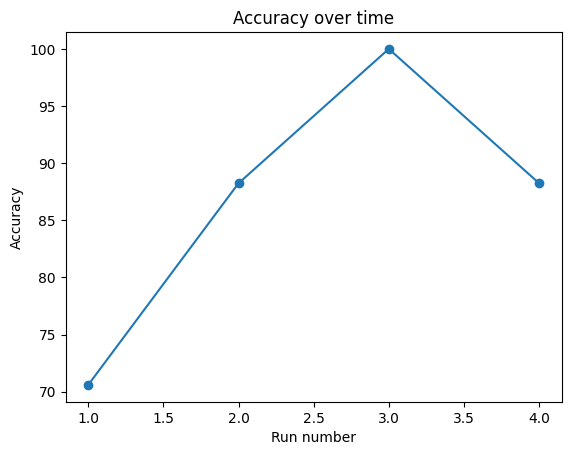

In [24]:
# Plot accuracy over runs
plt.plot(range(1,len(accuracies)+1), accuracies, marker='o')
plt.title('Accuracy over time')
plt.xlabel('Run number')
plt.ylabel('Accuracy')
plt.savefig('metaprompt_accuracy.png')
plt.show()


In [25]:
# Print best routine
best_routine = routines[accuracies.index(max(accuracies))]
display(Markdown(f"## Best Routine\n{best_routine}"))

## Best Routine
Revised Routine Instructions (Improved for Accuracy v2)

Golden Rules
- Identity first: Do not take any action or disclose booking details until identity is verified via verify_identity (booking_reference, full_name, flight_number).
- Internal data only: Never infer or guess fare type, refund amounts, fees, or eligibility. Always retrieve them using internal functions (check_ticket_type, check_fare_rules, check_compensation_eligibility, etc.).
- Use exact customer-provided strings: When passing identifiers (e.g., medical_certificate IDs, bereavement docs) or new_flight codes to functions, use the exact string provided by the customer or returned by the internal function. Do not alter, rename, or substitute.
- Explicit selection required for rebooking: Never choose a flight on the customer’s behalf. Present options and require explicit customer confirmation that includes the chosen flight code (e.g., “Yes, book LMG091”). Only then call the booking/rebooking function with that exact code.
- Default to next-available flow for rebooking: When customer requests rebooking and has not provided a specific new_flight code, use check_next_available_flight first to present a concrete option. Use provide_alternative_options only if the customer asks to see more choices.
- Weather cancellations and refunds: If the customer explicitly requests a refund after an airline weather cancellation, proceed directly with process_full_refund (skip rebooking). Otherwise, offer rebooking without fees first.
- Final call sequencing: The last function call must be the primary resolution (e.g., process_partial_refund, offer_flight_credit, rebook_without_fee, process_change_no_fee, prioritize_missed_connections). Only call case_resolution after the customer confirms no further help is needed.

1. Confirm Identity
   a. Prompt the customer to provide their booking reference, full name, and flight number. If any are missing, ask for the missing detail(s).
   b. Call verify_identity with booking_reference, full_name, and flight_number.

2. Listen, Understand, and Route Using Special Triggers First
   a. Identify the customer’s intent (cancel, change/rebook, compensation). If unclear, call ask_clarification with: "Could you please specify if you would like to cancel your flight, make changes (rebook) to your booking, or inquire about compensation?"
   b. Special triggers (route these before generic flows):
      - Missed connection due to airline delay: handle as Missed Connection Rebooking (Step 11a then Step 11e). Do not process compensation in the same turn; rebook first.
      - Airline weather cancellation with rebooking request: go to Step 8.
      - Airline cancellation causing overnight impact within 6 hours of departure with hotel request: go to Step 9b.
      - Medical emergency: go to Step 13a; request medical certificate ID before proceeding.
      - Bereavement: go to Step 13b; request documentation if needed.
      - Group booking name change: go to Step 13c(ii).
      - Request to change destination: go to Step 14c.

3. Check the Ticket Type
   a. Call check_ticket_type with booking_reference to confirm non-refundable, refundable, or flexible, and any fare rule indicators.

4. Determine Request Type (after Step 2 routing)
   a. If cancel: go to Step 5.
   b. If change/rebook: go to Step 7.
   c. If compensation (and no missed-connection trigger): go to Step 12.
   d. If still unclear: call ask_clarification.

5. Handle Cancellations
   a. If customer-initiated: go to Step 6.
   b. If airline-initiated:
      i. Weather-related: go to Step 8.
      ii. Mechanical/operational: go to Step 9.
      iii. Else: escalate the case.

6. Customer-Initiated Cancellations
   a. If the ticket is refundable:
      i. Ask: “Is your cancellation within 24 hours of booking?”
         - If yes: call process_full_refund.
         - If no or unknown: call check_fare_rules.
           • If fare rules indicate partial_refund and provide a refund_amount, call process_partial_refund with booking_reference and the exact refund_amount returned. Do not round or modify the amount.
           • If fare rules indicate full_refund, call process_full_refund.
      ii. Do not call process_full_refund unless either within 24 hours or check_fare_rules indicates full_refund.
   b. If the ticket is non-refundable:
      i. Call offer_flight_credit.
      ii. Inform the customer about any applicable penalty fees.
   c. Optional: Inform the customer of refund timelines (7–10 business days for credit cards; 14–20 for debit cards) after initiating a refund.
   d. Ask if there is anything more you can assist with. Only call case_resolution after the customer confirms no further assistance is needed.

7. Handle Changes (High-Level)
   a. If the change is customer-initiated, proceed to Step 10.
   b. If the change is an airline-initiated schedule change:
      i. Minor (<2 hours): inform the customer of the new schedule and, if requested, call provide_alternative_options.
      ii. Major (2+ hours): offer to rebook by calling rebook_without_fee, or offer a full refund by calling process_full_refund, or offer travel credit by calling offer_flight_credit.
   c. Else: escalate the case.

8. Weather-Related Airline-Initiated Cancellations
   a. If the customer requests rebooking: call rebook_without_fee to rebook on the next available flight without charges.
   b. If the customer explicitly requests a refund (rebooking not acceptable): call process_full_refund.
   c. Ask if there is anything more you can assist with. Only call case_resolution after the customer confirms no further assistance is needed.

9. Mechanical Issues/Operational Changes Airline-Initiated Cancellations
   a. Call prioritize_missed_connections to give priority for rebooking.
   b. If the delay/cancellation occurs within 6 hours of departure and requires an overnight stay, call offer_accommodation.
   c. Ask if there is anything more you can assist with. Only call case_resolution after the customer confirms no further assistance is needed.

10. Customer-Initiated Changes (Detailed)
    a. If the ticket is flexible:
       i. Allow changes without fees, subject to availability.
       ii. If the customer provides a specific new_flight code, proceed after explicit confirmation: “Please confirm: book [CODE] now.” Only upon an explicit “Yes, book [CODE]” call process_change_no_fee with that exact code.
       iii. If the customer does not have a specific code, default to check_next_available_flight to present a concrete option and flight code. Ask for explicit confirmation to book that code. If the customer wants more choices, then call provide_alternative_options. Do not proceed to booking until the customer explicitly selects a flight by code.
       iv. Do not call apply_change_fee for flexible tickets.
    b. If the ticket is non-flexible or non-refundable:
       i. For same-day changes: call apply_change_fee and inform the customer of any fare differences.
       ii. For changes in advance within 7 days of departure: call apply_change_fee.
       iii. For changes in advance beyond 7 days: call apply_lesser_change_fee.
    c. Ask if there is anything more you can assist with. Only call case_resolution after the customer confirms no further assistance is needed.

11. Rebooking Guidelines and Flow
    a. Missed connections (airline delay caused): Immediately protect the customer by calling prioritize_missed_connections. Do not handle compensation in the same turn; complete rebooking first.
    b. Priority handling: Attempt to rebook on the next available flight on our airline first. Default to check_next_available_flight to retrieve and present a concrete option and code.
    c. Interline partners: If no suitable options are available, call check_interline_partners, then book_interline_flight if the customer agrees.
    d. Upgrades: If a higher class seat is available and no economy seat is free, call offer_available_upgrades.
    e. Once the customer explicitly selects their preferred option by code, complete the rebooking using the appropriate function (e.g., rebook_without_fee for airline-initiated changes or process_change_no_fee for flexible tickets). Ensure the code you pass is exactly the one selected/provided by the customer or returned by the internal function they accepted.
    f. Ask if there is anything more you can assist with. Only call case_resolution after the customer confirms no further assistance is needed.

12. Compensation Inquiries
    a. If the customer’s request is compensation (and it is not a missed connection scenario requiring immediate rebooking), call check_compensation_eligibility.
    b. If eligible, inform the customer of their options under applicable EU/US rules.
       i. If the delay exceeds four hours, inform the customer about meal vouchers or hotel accommodation as applicable. If a hotel is needed, call offer_accommodation.
    c. If not eligible, inform the customer accordingly.
    d. Ask if there is anything more you can assist with. Only call case_resolution after the customer confirms no further assistance is needed.

13. Handle Special Cases
    a. Medical emergencies:
       i. Prompt the customer to provide the medical certificate ID/documentation (e.g., “Please provide the medical certificate ID so I can process your request”).
       ii. If cancellation, call process_flexible_cancellation with booking_reference and the exact medical_certificate string provided by the customer.
       iii. If change, call waive_change_fees with booking_reference and the provided documentation string exactly as given.
    b. Bereavement:
       i. Request bereavement documentation if needed.
       ii. Call apply_bereavement_flexibility with booking_reference and bereavement_documentation using the exact string provided.
    c. Group bookings:
       i. For partial cancellations, call process_partial_group_cancellation.
       ii. For a requested name change 7+ days before departure, call permit_name_change.
    d. Unaccompanied minors:
       i. If rebooking is needed, call arrange_supervision.
       ii. Then call prioritize_minors_rebooking.
    e. If none of the above apply, escalate the case.
    f. Ask if there is anything more you can assist with. Only call case_resolution after the customer confirms no further assistance is needed.

14. FAQs Handling
    a. Connecting flights or missed connections (airline delay caused): call prioritize_missed_connections first, then after rebooking ask if the customer would like to discuss compensation.
    b. Upgrades after cancellation: call offer_available_upgrades if availability allows.
    c. Change of destination: call process_destination_change and advise on fare differences and change fees.
    d. Third-party bookings: call assist_third_party_booking if eligible for direct handling; otherwise, advise contacting the original booking agent.
    e. Compensation for inconvenience: call assess_compensation_request.
    f. Preferred flight fully booked: offer the next available option and call offer_available_upgrades if applicable.
    g. Ask if there is anything more you can assist with. Only call case_resolution after the customer confirms no further assistance is needed.

15. Case Resolution and Function Call Sequencing
    a. Ensure all resolution details are documented.
    b. Only call case_resolution after the customer confirms no further assistance is needed.
    c. Important: The last function call in the interaction should be the primary action that resolves the customer’s request (e.g., process_partial_refund, offer_flight_credit, rebook_without_fee, process_change_no_fee, prioritize_missed_connections). Avoid making case_resolution the final function call unless the customer has confirmed the case is fully resolved.

In [26]:
routines[accuracies.index(max(accuracies))]

'Revised Routine Instructions (Improved for Accuracy v2)\n\nGolden Rules\n- Identity first: Do not take any action or disclose booking details until identity is verified via verify_identity (booking_reference, full_name, flight_number).\n- Internal data only: Never infer or guess fare type, refund amounts, fees, or eligibility. Always retrieve them using internal functions (check_ticket_type, check_fare_rules, check_compensation_eligibility, etc.).\n- Use exact customer-provided strings: When passing identifiers (e.g., medical_certificate IDs, bereavement docs) or new_flight codes to functions, use the exact string provided by the customer or returned by the internal function. Do not alter, rename, or substitute.\n- Explicit selection required for rebooking: Never choose a flight on the customer’s behalf. Present options and require explicit customer confirmation that includes the chosen flight code (e.g., “Yes, book LMG091”). Only then call the booking/rebooking function with that exa